In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.interpolate import interp1d
from scipy.signal import resample, find_peaks, peak_prominences
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import LeaveOneOut
from lightgbm import LGBMRegressor
import sys
from tqdm import tqdm
from datetime import datetime

from truth import IeeeGroundTruth
from wavelet import apply_wavelet
from peaks import get_peaks_v2
from signal_pross import (
    normalize_signal,
    detrend_w_poly,
    normalize_amplitude_to_1,
    n_moving_avg,
    min_max_scale,
    bandpass,
    get_hr
)
import lightgbm as lgb
from autograd import grad

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

### Process data for all 7 subjects

In [2]:
truths = []
for subject in range(1, 8):

    truth = IeeeGroundTruth(subject, 1, directory = 'channel_data3')
    truth.align_rgb_bvp()
    truth.fill_nans()
    truth.process_rgb()
    truth.process_bvp()

    truths.append(truth)

In [3]:
import autograd.numpy as anp
from autograd import grad, hessian

def basic_err(err):
    return anp.mean(anp.square(err))

# def autograd_hr_err(vec):

#     n = vec // 2
#     y_true = vec[0: n]
#     y_pred = vec[n: ]

#     pred_peaks, _ = get_peaks_v2(y_pred, 64, 3.0, -1, prominence = 0.1, with_min_dist = True, with_valleys = False)
#     true_peaks, _ = get_peaks_v2(y_true, 64, 3.0, -1, prominence = 0, with_min_dist = True, with_valleys = False)

#     true_ibis = get_ibis(true_peaks, 64)
#     true_hr = 60 / np.mean(true_ibis)

#     if len(pred_peaks) >= 2:
#         pred_ibis = get_ibis(pred_peaks, 64)
#         pred_hr = 60 / np.mean(pred_ibis)
#     else:
#         pred_hr = 0
    
#     err = true_hr - pred_hr
#     return err


grad_err = grad(basic_err)
hess_err = hessian(basic_err)

In [4]:
def _process(targs, signal, smoothing_window = 10, use_bandpass = False):
    
    orig_len = len(signal)
    signal = n_moving_avg(signal, smoothing_window)
    signal = resample(signal, orig_len)
    if use_bandpass:
        signal = bandpass(signal, 64, [0.67, 3.0], 4)
    signal = min_max_scale(signal)
    
    targs = n_moving_avg(targs, 20)
    targs = resample(targs, orig_len)
    targs = min_max_scale(targs)
    
    return targs, signal

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
import torch
import multiprocessing as mp
import concurrent.futures as cf
from joblib import Parallel, delayed
import autograd.numpy as anp
import torch.nn.functional as F


def calculate_gradients_hessians(args):
    i, y_pred, y_true, split_size, gradient_func, hessian_func = args
    y_pred_curr = y_pred[i * split_size: (i + 1) * split_size]
    y_true_curr = y_true[i * split_size: (i + 1) * split_size]
    comb = torch.cat((torch.tensor(y_true_curr, requires_grad = True), torch.tensor(y_pred_curr, requires_grad = True)))

    grad_curr = gradient_func(comb)[split_size:]
    hess_curr = torch.diagonal(hessian_func(comb))[split_size: ]
    return i, grad_curr, hess_curr

def spectral_loss_helper(vec):
    s = len(vec) // 2
    y_true = vec[:s]
    y_pred = vec[s:]
    y_true_fft = torch.fft.rfft(y_true)
    y_pred_fft = torch.fft.rfft(y_pred)
    return torch.mean(torch.abs(torch.square(y_true_fft - y_pred_fft)))

spectral_loss_grad_func = lambda x: torch.autograd.grad(spectral_loss_helper(x), x)[0]
spectral_loss_hess_func = lambda x: torch.autograd.functional.hessian(spectral_loss_helper, x)

def calculate_gradients_hessians_dsc(args):
    i, y_pred, y_true, split_size, gradient_func, hessian_func = args
    y_pred_curr = y_pred[i * split_size: (i + 1) * split_size]
    y_true_curr = y_true[i * split_size: (i + 1) * split_size]
    # comb = torch.cat((torch.tensor(y_true_curr, requires_grad=True), torch.tensor(y_pred_curr, requires_grad=True)))
    comb = torch.cat((y_true_curr, y_pred_curr))

    grad_curr = gradient_func(comb)[split_size:]
    hess_curr = torch.diagonal(hessian_func(comb))[split_size:]
    return i, grad_curr, hess_curr

def dsc_loss_helper(vec):
    s = len(vec) // 2
    y_true = vec[0:s]
    y_pred = vec[s:]

    window_size = 256
    n_fft = 256
    hop_length = 128

    y_true_stft = torch.stft(y_true, n_fft=n_fft, hop_length=hop_length, window=torch.hann_window(window_size), center=False, return_complex=True)
    y_pred_stft = torch.stft(y_pred, n_fft=n_fft, hop_length=hop_length, window=torch.hann_window(window_size), center=False, return_complex=True)
    y_true_mag = torch.abs(y_true_stft)
    y_pred_mag = torch.abs(y_pred_stft)
    return torch.mean((y_true_mag - y_pred_mag)**2)

def dsc_loss_grad_func(x):
    return torch.autograd.grad(dsc_loss_helper(x), x)[0]

def dsc_loss_hess_func(x):
    return torch.autograd.functional.hessian(dsc_loss_helper, x)

# def differentiable_peak_find(signal, prominence=0, distance=0):
#     dy = torch.diff(signal)
#     ddy = torch.diff(dy)

#     zero_crossings = torch.where((dy[:-1] > 0) & (dy[1:] <= 0))[0]
#     peaks = []
#     for zc in zero_crossings:
#         if ddy[zc] < 0 and signal[zc] >= prominence:
#             # Check that this peak is far enough away from the previous one
#             if len(peaks) == 0 or zc - peaks[-1] >= distance:
#                 peaks.append(zc)

#     return torch.tensor(peaks)
def differentiable_peak_find(signal, window_size=3, prominence=0, distance=1):
    if not isinstance(signal, torch.Tensor):
        signal = torch.tensor(signal, dtype=torch.float32, requires_grad=True)

    padding = (window_size - 1) // 2
    padded_signal = F.pad(signal.unsqueeze(0).unsqueeze(0), (padding, padding), mode='replicate')
    rolling_max = F.max_pool1d(padded_signal, window_size, stride=1).squeeze(0).squeeze(0)

    local_maxima = (signal == rolling_max) & (signal >= prominence)

    if distance > 1:
        distance_mask = torch.zeros_like(signal)
        distance_mask[::distance] = 1
        local_maxima = local_maxima & distance_mask.bool()

    peak_indices = torch.nonzero(local_maxima).squeeze()
    return peak_indices

# def hr_loss_helper(vec):
#     s = len(vec) // 2
#     y_true = vec[0:s]
#     y_pred = vec[s:]

#     y_true_peaks = differentiable_peak_find(y_true)
#     y_pred_peaks = differentiable_peak_find(y_pred)

#     y_true_ibis = torch.diff(y_true_peaks) / 64
#     y_pred_ibis = torch.diff(y_pred_peaks) / 64

#     if len(y_true_ibis) < 2:
#         y_true_hr = 0   
#     else:
#         y_true_hr = 60 / torch.mean(y_true_ibis)

#     if len(y_pred_ibis) < 2:
#         y_pred_hr = 0
#     else:
#         y_pred_hr = 60 / torch.mean(y_pred_ibis)

#     res = torch.pow(y_true_hr - y_pred_hr, 2)
#     res.requires_grad = True
#     return res

def hr_loss_helper(vec):
    s = len(vec) // 2
    y_true = torch.tensor(vec[0:s], requires_grad=True)
    y_pred = torch.tensor(vec[s:], requires_grad=True)

    true_peak_indices = F.max_pool1d(y_true.unsqueeze(0), kernel_size=3, stride=1, padding=1) == y_true.unsqueeze(0)
    pred_peak_indices = F.max_pool1d(y_pred.unsqueeze(0), kernel_size=3, stride=1, padding=1) == y_pred.unsqueeze(0)

    true_ibis = torch.diff(torch.diff(torch.nonzero(true_peak_indices)).squeeze() / 64)
    pred_ibis = torch.diff(torch.diff(torch.nonzero(pred_peak_indices)).squeeze() / 64)

    true_hr = 60.0 / true_ibis.mean()
    pred_hr = 60.0 / pred_ibis.mean()

    mse = F.mse_loss(torch.tensor(true_hr), torch.tensor(pred_hr))
    return mse

def calculate_gradients_hessians_hr_err(args):
    i, y_pred, y_true, split_size, gradient_func, hessian_func = args
    y_pred_curr = y_pred[i * split_size: (i + 1) * split_size]
    y_true_curr = y_true[i * split_size: (i + 1) * split_size]
    comb = torch.cat((torch.tensor(y_true_curr, requires_grad=True), torch.tensor(y_pred_curr, requires_grad=True)))

    grad_curr = gradient_func(comb)[split_size:]
    hess_curr = torch.diagonal(hessian_func(comb))[split_size:]
    return i, grad_curr, hess_curr

    
def hr_loss_grad_func(x):
    return torch.autograd.grad(hr_loss_helper(x), x, allow_unused = True)[0]

def hr_loss_hess_func(x):
    return torch.autograd.functional.hessian(hr_loss_helper, x, allow_unused = True)


def MoodyLossFactory(n, split_size, loss_type = 'mse'):

    def basic_error(y_pred, data):
        
        y_true = data.get_label()
        num_batches = int(n / split_size)
        err = 0
        
        for i in range(num_batches):
            y_true_curr = y_true[i * split_size: (i + 1) * split_size]
            y_pred_curr = y_pred[i * split_size: (i + 1) * split_size]
            err += y_pred_curr - y_true_curr
        
        grad = 2 * err
        hess = 0 * err + 2
        return grad, hess
    
    def custom_mse(y_pred, data):

        y_true = data.get_label()
        num_batches = int(n / split_size)
        errs = np.zeros_like(y_true)
        
        for i in range(num_batches):
            y_true_curr = y_true[i * split_size: (i + 1) * split_size]
            y_pred_curr = y_pred[i * split_size: (i + 1) * split_size]
            err = y_true_curr - y_pred_curr
            errs[i * split_size: (i + 1) * split_size] = err
        
        grad = -2 * errs
        hess = 2 * np.ones_like(y_true)
        return grad, hess
    
    def spectral_error(y_pred, data):
        y_true = data.get_label()
        
        num_batches = int(len(y_true) / split_size)
        gradients = np.zeros_like(y_true)
        hessians = np.zeros_like(y_true)

        args_list = [(i, y_pred, y_true, split_size, spectral_loss_grad_func, spectral_loss_hess_func) for i in range(num_batches)]
        results = Parallel(n_jobs=-1)(delayed(calculate_gradients_hessians)(args) for args in args_list)
        
        for i, grad_curr, hess_curr in results:
            gradients[i * split_size: (i + 1) * split_size] = grad_curr
            hessians[i * split_size: (i + 1) * split_size] = hess_curr

        return gradients, hessians

    def dsc_loss(y_pred, data):
        y_true = data.get_label()
        y_true = torch.tensor(y_true, dtype=torch.float32)
        y_pred = torch.tensor(y_pred, requires_grad=True, dtype=torch.float32)

        n = len(y_true)
        num_batches = int(n / split_size)
        gradients = np.zeros_like(y_true)
        hessians = np.zeros_like(y_true)

        args_list = [(i, y_pred, y_true, split_size, dsc_loss_grad_func, dsc_loss_hess_func) for i in range(num_batches)]
        results = Parallel(n_jobs=-1)(delayed(calculate_gradients_hessians_dsc)(args) for args in args_list)

        for i, grad_curr, hess_curr in results:
            gradients[i * split_size: (i + 1) * split_size] = grad_curr
            hessians[i * split_size: (i + 1) * split_size] = hess_curr

        return gradients, hessians

    def hr_loss(y_pred, data):
        print('in it')
        t1 = datetime.today()
        y_true = data.get_label()
        y_true = torch.tensor(y_true, dtype=torch.float32)
        y_pred = torch.tensor(y_pred, requires_grad=True, dtype=torch.float32)
        print('sam 1')

        n = len(y_true)
        num_batches = int(n / split_size)
        gradients = np.zeros_like(y_true)
        hessians = np.zeros_like(y_true)
        print('sam 2')

        # args_list = [(i, y_pred, y_true, split_size, hr_loss_grad_func, hr_loss_hess_func) for i in range(num_batches)]
        # results = Parallel(n_jobs=1)(delayed(calculate_gradients_hessians_hr_err)(args) for args in args_list)

        for i in range(num_batches):

            y_pred_curr = y_pred[i * split_size: (i + 1) * split_size]
            y_true_curr = y_true[i * split_size: (i + 1) * split_size]
            comb = torch.cat((torch.tensor(y_true_curr, requires_grad=True), torch.tensor(y_pred_curr, requires_grad=True)))
            print('sam 3')
            grad_curr = hr_loss_grad_func(comb)[split_size: ]
            print('sam 3.25')
            hess_curr = torch.diagonal(hr_loss_grad_func(comb))[split_size ]
            print('sam 3.5')
            gradients[i * split_size: (i + 1) * split_size] = grad_curr
            hessians[i * split_size: (i + 1) * split_size] = hess_curr
            print('sam 4')


        # for i, grad_curr, hess_curr in results:
        #     gradients[i * split_size: (i + 1) * split_size] = grad_curr
        #     hessians[i * split_size: (i + 1) * split_size] = hess_curr

        print(f'HR loss time: {datetime.today() - t1}')
        return gradients, hessians

    
    if loss_type not in ['basic', 'mse', 'hr', 'spectral', 'dsc']:
        raise ValueError(f'Loss type [{loss_type}] not supported')

    if loss_type == 'basic':
        return basic_error
    elif loss_type == 'mse':
        return custom_mse
    elif loss_type == 'hr':
        return hr_loss
    elif loss_type == 'spectral':
        return spectral_error
    elif loss_type == 'dsc':
        return dsc_loss


### Implement custom subclass of SKLearn's RF Regressor

In [33]:
class MoodyGBM:
    
    def __init__(self, data, label_col = 'bvp', subject_col = 'subject', random_state = 0, kfold = False, loss_type = 'hr',
                # hyperparameters
                n_estimators = 100, objective = None, split_size = 320, test_size = 0.3):
        
        # instance variables
        self.given_data = data
        self.label_col = label_col
        self.subject_col = subject_col
        self.split_size = split_size
        self.test_size = test_size
        self.random_state = random_state
        self.kfold = kfold
        self.tree_weights_ = None
        self.n_estimators = n_estimators
        self.gbm = None

        self.sam = {}
        self.c = 0

        # create consecutive splits in the data and then randomly sample from the splits
        splits = self.split_data()
        random.seed(self.random_state)
        self.train_split_indices = random.sample(range(len(splits)), int(len(splits) * (1 - self.test_size)))
        
        # split up the training and testing splits
        self.train_splits = [splits[i] for i in self.train_split_indices]
        self.test_splits = [splits[i] for i in range(len(splits)) if i not in self.train_split_indices]
        
        # create the training dataset from the training splits
        train_indices = [idx for split in self.train_splits for idx in split]
        self.train_data = self.given_data.iloc[train_indices].drop(columns = [self.subject_col])
        # self.data = lgb.Dataset(self.train_data, label = self.label_col)
        self.train_X = self.train_data.drop(columns = [self.label_col]).to_numpy()
        self.train_y = self.train_data[self.label_col].to_numpy()

        # create the testing dataset from the testing splits
        test_indices = [idx for split in self.test_splits for idx in split]
        self.test_data = self.given_data.iloc[test_indices].drop(columns = [self.subject_col])
        self.test_X = self.test_data.drop(columns = [self.label_col]).to_numpy()
        self.test_y = self.test_data[self.label_col].to_numpy()

        self.train_data = lgb.Dataset(self.train_X, self.train_y)
        self.test_data = lgb.Dataset(self.test_X, self.test_y)

        self.loss = MoodyLossFactory(len(self.train_X), self.split_size, loss_type)

    def split_data(self, to_exclude = None):
        
        data_in_use = self.given_data if to_exclude is None else self.given_data[~self.given_data[self.subject_col].isin(to_exclude)]

        subject_indices = data_in_use.groupby(self.subject_col).indices
        splits = []
        for _, indices in subject_indices.items():
            
            n_splits = len(indices) // self.split_size
            if n_splits > 0:

                subject_splits = []
                for i in range(n_splits):
                    split_start = i * self.split_size
                    split_end = (i + 1) * self.split_size
                    subject_split = indices[split_start: split_end]
                    subject_splits.append(subject_split)
                
                splits.extend(subject_splits)
        
        return splits

    def fit(self):
        t1 = datetime.today()
        params = {
            'metric': 'None',
            'verbosity': -1,
            'seed': self.random_state
            # 'objective': 'regression'
            # 'n_iterations': self.n_estimators
        }
        self.gbm = lgb.train(params, self.train_data, fobj = self.loss, num_boost_round = self.n_estimators)
        print(f'Finished training in {datetime.today() - t1}')

    def predict(self, X):
        return self.gbm.predict(X)

    def eval(self):
        
        errs = []
        nsplits = int(len(self.test_X) / self.split_size)
        for i in range(nsplits):

            curr_pred = self.predict(self.test_X[i * self.split_size: (i + 1) * self.split_size, :])
            curr_true = self.test_y[i * self.split_size: (i + 1) * self.split_size]
            curr_true, curr_pred = _process(curr_true, curr_pred)

            pred_peaks, _ = get_peaks_v2(curr_pred, 64, 3.0, -1, prominence = 0.1, with_min_dist = True, with_valleys = False)
            true_peaks, _ = get_peaks_v2(curr_true, 64, 3.0, -1, prominence = 0, with_min_dist = True, with_valleys = False)

            # true_ibis = get_ibis(true_peaks, 64)
            true_ibis = np.diff(true_peaks) / 64
            true_hr = 60 / np.mean(true_ibis)

            if len(pred_peaks) >= 2:
                pred_ibis = np.diff(pred_peaks) / 64
                pred_hr = 60 / np.mean(pred_ibis)
            else:
                pred_hr = 0
            
            errs.append(abs(true_hr - pred_hr))
        
        return np.mean(errs), np.mean(np.square(errs))
    
    @staticmethod
    def get_hr_err(vec):

        def anp_get_hr(ibis):
            return 60 / anp.mean(ibis)


        n = len(vec) // 2
        true_ibis = vec[0: n]
        pred_ibis = vec[n: ]

        true_hr = anp_get_hr(true_ibis)
        pred_hr = anp_get_hr(pred_ibis)    
        return anp.power(true_hr - pred_hr, 2)


### Train the model on all subjects except 1

In [45]:
test_subject = 7
test_subject_truth = truths[test_subject - 1]

data_arr = []
for i in range(len(truths)):
    
    if i == (test_subject - 1):
        continue
    
    truth = truths[i]
    data = truth.prepare_data_for_ml()
    data = data.iloc[1000: 15000, :]
    
    data['subject'] = i + 1
    data_arr.append(data)

data = pd.concat(data_arr)

mod = MoodyGBM(data, n_estimators = 800, loss_type = 'mse')
mod.fit()
hr_err, hr_err_sq = mod.eval()

print(f'HR error: {hr_err}')
print(f'HR error squared: {hr_err_sq}')


Finished training in 0:00:02.105427
HR error: 19.72619431830494
HR error squared: 626.1129452653973


In [30]:
test_subject = 7
test_subject_truth = truths[test_subject - 1]

data_arr = []
for i in range(len(truths)):
    
    if i == (test_subject - 1):
        continue
    
    truth = truths[i]
    data = truth.prepare_data_for_ml()
    data = data.iloc[1000: 15000, :]
    
    data['subject'] = i + 1
    data_arr.append(data)

data = pd.concat(data_arr)

mod = MoodyGBM(data, n_estimators = 500, loss_type = 'mse')
mod.fit()
hr_err, hr_err_sq = mod.eval()

print(f'HR error: {hr_err}')
print(f'HR error squared: {hr_err_sq}')

Finished training in 0:00:01.427531
HR error: 20.098441815709517
HR error squared: 647.4082418708233


In [9]:
# test_subject = 7
# test_subject_truth = truths[test_subject - 1]

# data_arr = []
# for i in range(len(truths)):
    
#     if i == (test_subject - 1):
#         continue
    
#     truth = truths[i]
#     data = truth.prepare_data_for_ml()
#     data = data.iloc[1000: 15000, :]
    
#     data['subject'] = i + 1
#     data_arr.append(data)

# data = pd.concat(data_arr)

# rf2 = MoodyGBM(data, n_estimators = 10)
# rf2.fit()
# hr_err, hr_err_sq = rf2.eval()

# print(f'HR error: {hr_err}')
# print(f'HR error squared: {hr_err_sq}')
# # print(f'HR error: {hr_errs}')
# # print(f'HR Error absolute: {hr_errs_absolute}')
# # print(f'Feature importances:')
# # display(rf.feature_importances())

In [10]:
# test_subject = 7
# test_subject_truth = truths[test_subject - 1]

# data_arr = []
# for i in range(len(truths)):
    
#     if i == (test_subject - 1):
#         continue
    
#     truth = truths[i]
#     data = truth.prepare_data_for_ml()
#     data = data.iloc[1000: 15000, :]
    
#     data['subject'] = i + 1
#     data_arr.append(data)

# data = pd.concat(data_arr)

# rf3 = MoodyGBM(data, n_estimators = 20)
# rf3.fit()
# hr_err, hr_err_sq = rf3.eval()

# print(f'HR error: {hr_err}')
# print(f'HR error squared: {hr_err_sq}')
# print(f'HR error: {hr_errs}')
# print(f'HR Error absolute: {hr_errs_absolute}')
# print(f'Feature importances:')
# display(rf.feature_importances())

In [11]:
# test_subject = 7
# test_subject_truth = truths[test_subject - 1]

# data_arr = []
# for i in range(len(truths)):
    
#     if i == (test_subject - 1):
#         continue
    
#     truth = truths[i]
#     data = truth.prepare_data_for_ml()
#     data = data.iloc[1000: 15000, :]
    
#     data['subject'] = i + 1
#     data_arr.append(data)

# data = pd.concat(data_arr)

# rf4 = MoodyGBM(data, n_estimators = 100)
# rf4.fit()
# hr_err, hr_err_sq = rf4.eval()

# print(f'HR error: {hr_err}')
# print(f'HR error squared: {hr_err_sq}')
# print(f'HR error: {hr_errs}')
# print(f'HR Error absolute: {hr_errs_absolute}')
# print(f'Feature importances:')
# display(rf.feature_importances())

In [12]:
# test_subject = 7
# test_subject_truth = truths[test_subject - 1]

# data_arr = []
# for i in range(len(truths)):
    
#     if i == (test_subject - 1):
#         continue
    
#     truth = truths[i]
#     data = truth.prepare_data_for_ml()
#     data = data.iloc[1000: 15000, :]
    
#     data['subject'] = i + 1
#     data_arr.append(data)

# data = pd.concat(data_arr)

# rf5 = MoodyGBM(data, n_estimators = 200)
# rf5.fit()
# hr_err, hr_err_sq = rf5.eval()

# print(f'HR error: {hr_err}')
# print(f'HR error squared: {hr_err_sq}')
# print(f'HR error: {hr_errs}')
# print(f'HR Error absolute: {hr_errs_absolute}')
# print(f'Feature importances:')
# display(rf.feature_importances())

In [13]:
# data_arr = []
# for i in range(len(truths)):
        
#     truth = truths[i]
#     data = truth.prepare_data_for_ml()
#     data = data.iloc[1000: 15000, :]
    
#     data['subject'] = i + 1
#     data_arr.append(data)

# data = pd.concat(data_arr)

# rf = MoodTriggersRegressor(data, n_estimators = 100, kfold = True)
# mean_mse, mean_hr_err, mean_sqrt_hr_err, summary = rf.eval_kfold()

# print(mean_mse, mean_hr_err, mean_sqrt_hr_err)
# summary

In [14]:
rec = {
    'w/o wave': (0.014966182095387174, 696.1679901518303),
    'w/ wave': (0.06851164298744652, 335.74974096112766),
    'w/ bandpass and wave w/ bandpass first': (0.02288918317382276, 883.0830443688016),
    'w/ bandpass and wave w/ wave first': (0.013029571137835922, 619.7491567908635),
    'w/ min max scaling and everything else': (0.006137550724635535, 527.8052162904935),
    'w/ prev but also with chrom': (0.0053205282220937684, 532.8225611310841)
}

[0.64138657 0.63213568 0.62315547 0.61466351 0.60686152]
True HR: 47.174447174447174; Pred HR: 73.2425068119891


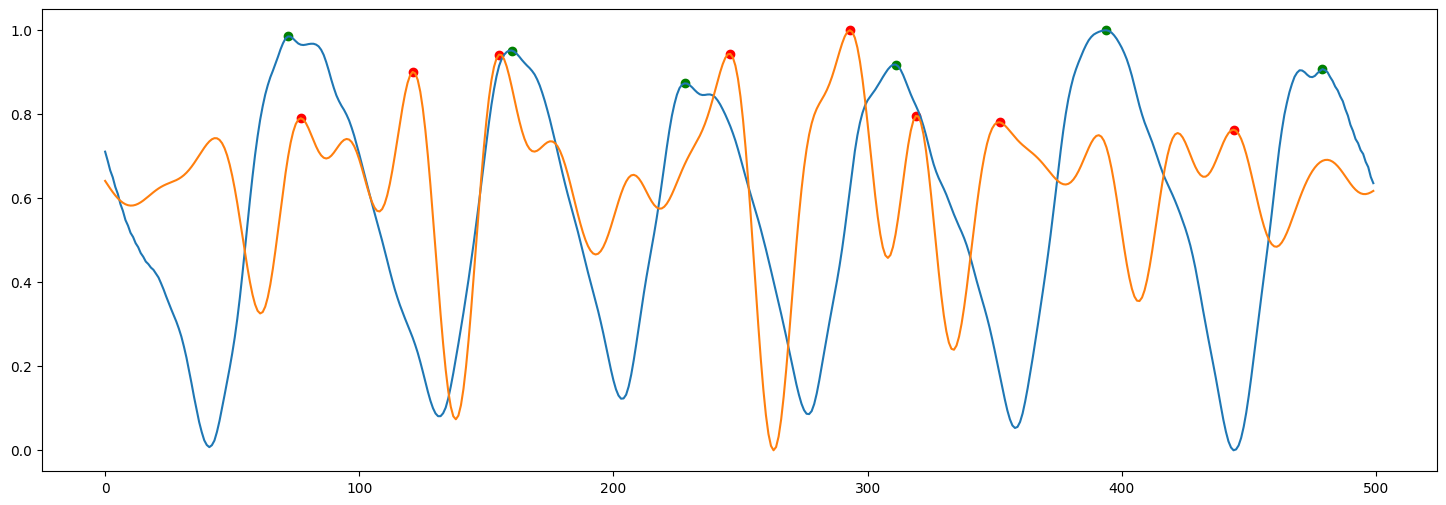

In [46]:
beg = 3000
end = 3500

model = mod

# get data for subject not in test set and get x and y for prediction
data = test_subject_truth.prepare_data_for_ml()
x = data.drop(columns = ['bvp']).to_numpy()
y = data['bvp'].to_numpy()

targ = y[beg: end]
pred = model.predict(x)[beg: end]
targ, pred = _process(targ, pred)
# pred = apply_wavelet(pred, 'db2', 2)
pred = bandpass(pred, 64, [0.67, 3.0], 4)
pred = min_max_scale(pred)
print(pred[0: 5])

pred_peaks, _ = get_peaks_v2(pred, 64, 3.0, 0.1, prominence = 0.2, with_min_dist = True, with_valleys = False)
true_peaks, _ = get_peaks_v2(targ, 64, 3.0, -1, prominence = 0.1, with_min_dist = True, with_valleys = False)

plt.plot(targ)
plt.plot(pred)
plt.scatter(pred_peaks, pred[pred_peaks], c='r')
plt.scatter(true_peaks, targ[true_peaks], c='g')

pred_ibis = np.diff(pred_peaks) / 64
true_ibis = np.diff(true_peaks) / 64
pred_hr = get_hr(pred_ibis)
true_hr = get_hr(true_ibis)
print(f'True HR: {true_hr}; Pred HR: {pred_hr}')
